In [1]:
! nvidia-smi

Tue Aug  3 15:30:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import re

## 데이터 불러오기

In [4]:
PATH = '..'
PATH = '/content/drive/MyDrive/Github/Ryles_Practice'
train_pos = pd.read_csv(PATH + "/DATA/open/train_pos.csv")
test_pos = pd.read_csv(PATH + "/DATA/open/test_pos.csv")

In [5]:
train_pos = train_pos.dropna()
test_pos = test_pos.fillna("없음")

In [6]:
train_name_key = [str(sent) for sent in train_pos['과제명'] + " " + train_pos['요약문_한글키워드']]
train_goal = [str(sent) for sent in train_pos['요약문_연구목표']]
train_cont = [str(sent) for sent in train_pos['요약문_연구내용']]
train_effect = [str(sent) for sent in train_pos['요약문_기대효과']]
test_name_key = [str(sent) for sent in test_pos['과제명'] + " " + test_pos['요약문_한글키워드']]
test_goal = [str(sent) for sent in test_pos['요약문_연구목표']]
test_cont = [str(sent) for sent in test_pos['요약문_연구내용']]
test_effect = [str(sent) for sent in test_pos['요약문_기대효과']]
train_label = [int(str(answer)) for answer in train_pos['label']]

In [7]:
# EDA
train_name_key_len = [len(str(sent).split()) for sent in train_name_key]
train_goal_len = [len(str(sent).split()) for sent in train_goal]
train_cont_len = [len(str(sent).split()) for sent in train_cont]
train_effect_len = [len(str(sent).split()) for sent in train_effect]
test_name_key_len = [len(str(sent).split()) for sent in test_name_key]
test_goal_len = [len(str(sent).split()) for sent in test_goal]
test_cont_len = [len(str(sent).split()) for sent in test_cont]
test_effect_len = [len(str(sent).split()) for sent in test_effect]

(array([3.5770e+03, 2.4114e+04, 1.3350e+04, 2.3770e+03, 1.4400e+02,
        1.2000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  2. ,  12.6,  23.2,  33.8,  44.4,  55. ,  65.6,  76.2,  86.8,
         97.4, 108. ]),
 <a list of 10 Patch objects>)

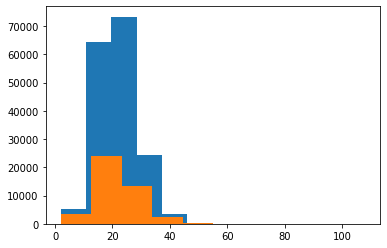

In [8]:
# name_key
import matplotlib.pyplot as plt
plt.hist(train_name_key_len)
plt.hist(test_name_key_len)

## max_len 30정도 주면 커버될 듯

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras import layers, models
import numpy as np

## tensorflow 모델 불러오기

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## train 데이터 만들기

In [11]:
def PAD(train_data, test_data, maxlen):
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(train_data)
    word_index = tokenizer.word_index
    train_seq = tokenizer.texts_to_sequences(train_data)
    test_seq = tokenizer.texts_to_sequences(test_data)
    train_pad = pad_sequences(train_seq, maxlen=maxlen, padding='post', truncating='post')
    test_pad = pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')
    vocab_size = len(word_index)+1 
    input_length = len(train_data)

    return train_pad, test_pad, vocab_size, input_length

In [12]:
train_pad, test_pad, vocab_size, input_length = PAD(train_name_key, test_name_key, 40)

## GRU 모델 학습 (optimizer = nadam / acivation = relu / softmax)

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length=40))
model.add(GRU(units=256, activation="relu", return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(46, activation='softmax'))
model.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 256)           14446080  
_________________________________________________________________
gru (GRU)                    (None, 40, 256)           394752    
_________________________________________________________________
dropout (Dropout)            (None, 40, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [14]:
history = model.fit(train_pad, np.array(train_label), epochs=17, batch_size=500, validation_split=0.2, verbose=2)

Epoch 1/17
274/274 - 72s - loss: 1.0594 - acc: 0.8128 - val_loss: 0.8229 - val_acc: 0.8163
Epoch 2/17
274/274 - 67s - loss: 0.7611 - acc: 0.8203 - val_loss: 0.7429 - val_acc: 0.8262
Epoch 3/17
274/274 - 67s - loss: 0.6367 - acc: 0.8310 - val_loss: 0.6274 - val_acc: 0.8390
Epoch 4/17
274/274 - 67s - loss: 0.5117 - acc: 0.8508 - val_loss: 0.5896 - val_acc: 0.8470
Epoch 5/17
274/274 - 67s - loss: 0.4222 - acc: 0.8725 - val_loss: 0.5967 - val_acc: 0.8521
Epoch 6/17
274/274 - 67s - loss: 0.3490 - acc: 0.8957 - val_loss: 0.5648 - val_acc: 0.8765
Epoch 7/17
274/274 - 67s - loss: 0.2883 - acc: 0.9138 - val_loss: 0.5764 - val_acc: 0.8820
Epoch 8/17
274/274 - 67s - loss: 0.2429 - acc: 0.9268 - val_loss: 0.5988 - val_acc: 0.8865
Epoch 9/17
274/274 - 67s - loss: 0.2071 - acc: 0.9375 - val_loss: 0.6430 - val_acc: 0.8911
Epoch 10/17
274/274 - 67s - loss: 0.1823 - acc: 0.9459 - val_loss: 0.6771 - val_acc: 0.8942
Epoch 11/17
274/274 - 68s - loss: 0.1597 - acc: 0.9525 - val_loss: 0.6978 - val_acc: 0.89

## 모델 예측

In [15]:
answer = model.predict(test_pad)

In [16]:
import tensorflow as tf

In [17]:
pred=tf.argmax(answer, axis=1)

In [19]:
import numpy as np

np.sum(pred!=0)

7825

In [25]:
sample_submission=pd.read_csv(PATH + '/DATA/open/sample_submission.csv')
sample_submission['label']=pred
sample_submission.to_csv(PATH + '/DATA/Result/GRU_name_key_max40.csv', index=False)